# Support Vector Machine

In [1]:
import optuna
from sklearn.svm import SVC
from src.preprocessing import *
from src.visualization import *
from src.trainer import *
from src.helpers import *
from src.config import *

In [2]:
model_name       = 'svm'
best_params_path = paths[model_name]['best_params']
model_path_list  = paths[model_name]['models']
pred_5folds_path = paths[model_name]['pred_5folds']
shap_fi_path     = paths[model_name]['shap_fi']

## 1. Load data

In [3]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in X_train_paths]
y_train_list = [pd.read_csv(path) for path in y_train_paths]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in X_val_paths]
y_val_list   = [pd.read_csv(path) for path in y_val_paths]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

## 2. Hyperparameters Tuning

In [4]:
def objective(trial):    
    param = {
        'C'           : trial.suggest_float('C', 100, 1000),
        'kernel'      : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma'       : trial.suggest_categorical('gamma', ['scale', 'auto']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'probability' : True,
        'random_state': RANDOM_STATE
    }
    if param['kernel'] == 'poly':
        param['degree'] = trial.suggest_int('degree', 2, 5)
    
    trainer = BaseTrainer(model=SVC(**param))
    mean_metrics, *_ = trainer.perform_cross_validation(
        X_train_list, y_train_list,
        X_val_list, y_val_list,
        verbose=0
    )
    avg = (mean_metrics.get('mean_accuracy') + mean_metrics.get('mean_f1_score') + mean_metrics.get('mean_roc_auc')) / 3
    return avg

In [5]:
HP_TUNING=False

if HP_TUNING:
    direction = 'maximize'
    n_trials  = 500
    n_jobs    = -1

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    best_params = study.best_trial.params
    best_params.update({
        'probability': True,
        'random_state': RANDOM_STATE
    })
else:
    best_params = load_json(best_params_path)
    
best_params

{'C': 115.15005747245534,
 'kernel': 'poly',
 'gamma': 'scale',
 'class_weight': 'balanced',
 'degree': 2,
 'probability': True,
 'random_state': 42}

## 3. Train with 5-fold cross validation

In [6]:
trainer = BaseTrainer(model=SVC(**best_params))
mean_metrics, y_pred_list, y_pred_proba_list, fi_list = trainer.perform_cross_validation(
    X_train_list=X_train_list,
    y_train_list=y_train_list,
    X_val_list=X_val_list,
    y_val_list=y_val_list,
    #model_path_list=model_path_list, # uncomment if you want to save newly trained models
    verbose=1,
)

Fold 1/5:
	- ACCURACY: 0.8000
	- ROC_AUC: 0.8867
	- F1_SCORE: 0.7755
	- MSE: 0.1482
	- PRECISION: 0.7917
	- RECALL: 0.7600
	- SPECIFICITY: 0.8333

Fold 2/5:
	- ACCURACY: 0.8909
	- ROC_AUC: 0.9413
	- F1_SCORE: 0.8846
	- MSE: 0.0999
	- PRECISION: 0.8519
	- RECALL: 0.9200
	- SPECIFICITY: 0.8667

Fold 3/5:
	- ACCURACY: 0.8182
	- ROC_AUC: 0.9040
	- F1_SCORE: 0.8077
	- MSE: 0.1237
	- PRECISION: 0.7778
	- RECALL: 0.8400
	- SPECIFICITY: 0.8000

Fold 4/5:
	- ACCURACY: 0.7593
	- ROC_AUC: 0.8593
	- F1_SCORE: 0.7347
	- MSE: 0.1512
	- PRECISION: 0.7500
	- RECALL: 0.7200
	- SPECIFICITY: 0.7931

Fold 5/5:
	- ACCURACY: 0.8148
	- ROC_AUC: 0.9145
	- F1_SCORE: 0.8077
	- MSE: 0.1250
	- PRECISION: 0.7778
	- RECALL: 0.8400
	- SPECIFICITY: 0.7931

------------------------------
	- MEAN_ACCURACY: 0.8166
	- MEAN_ROC_AUC: 0.9012
	- MEAN_F1_SCORE: 0.8020
	- MEAN_MSE: 0.1296
	- MEAN_PRECISION: 0.7898
	- MEAN_RECALL: 0.8160
	- MEAN_SPECIFICITY: 0.8172


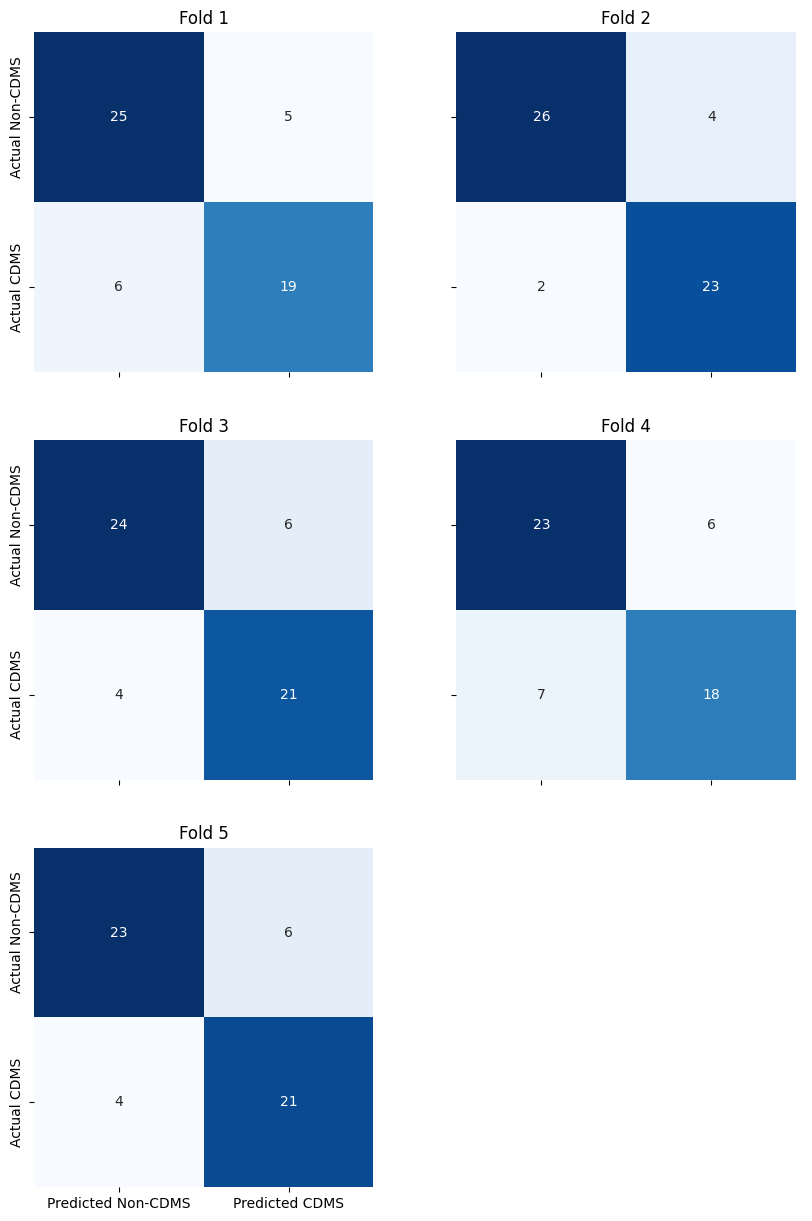

In [7]:
plot_confusion_matrix_folds(
    y_test_list=y_val_list,
    y_pred_list=y_pred_list,
)

## 4. Get predictions

In [8]:
analyzed_dfs = []

for fold in range(1, 6):
    # Load data for the current fold
    X_train, y_train, X_val, y_val = load_data_fold(fold)

    # Load trained model for the current fold
    model = load_model_fold(fold, model_name=model_name)

    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,-1]

    # Add ground truths and predictions to the current df
    analyzed_df = X_val.copy()
    analyzed_df['Actual'] = y_val
    analyzed_df['Predicted'] = y_pred
    analyzed_df['Predicted_Proba'] = y_pred_proba
    analyzed_dfs.append(analyzed_df)

analyzed_df_aggregated = pd.concat(analyzed_dfs, axis=0).reset_index(drop=True)
print(f'analyzed_df_aggregated.shape: {analyzed_df_aggregated.shape}')

# analyzed_df_aggregated.to_csv(pred_5folds_path, index=False)
# print(f'Save df to {pred_5folds_path}')

analyzed_df_aggregated.shape: (273, 23)


## 5. Explain with SHAP

In [9]:
import shap

models = [load_model_fold(fold+1, model_name) for fold in range(5)]
shap_values_folds = []

for fold in range(5):
    model = models[fold]
    X_train = X_train_list[fold]
    X_val = X_val_list[fold]

    explainer = shap.KernelExplainer(model.predict_proba, X_train, link="logit")
    shap_values = explainer.shap_values(X_val)
    sv = explainer.shap_values(X_val)
    mean_sv = np.mean(np.abs(sv), axis=0)
    shap_values_folds.append(mean_sv)

# Aggregate SHAP values across folds
aggregated_shap_values = np.mean(shap_values_folds, axis=0)

# Calculate mean absolute SHAP values for feature importance
feature_names = X_val_list[0].columns.to_list()
shap_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.mean(aggregated_shap_values, axis=1)
})

# Sort by importance
shap_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
#shap_feature_importance.to_csv(shap_fi_path, index=False)
shap_feature_importance

Using 218 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/55 [00:00<?, ?it/s]

KeyboardInterrupt: 